In [79]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import math
import cmath
from scipy import signal

In [2]:
# routines
def _shift(pair,shift):
    """shift t1 shift/2 samples to the left and
       shift t2 shift/2 samples to the right,
       if shift is odd move t1 the extra sample
       this process truncates trace length"""
    if shift == 0:
        return pair
    elif shift == 1:
        t1 = pair[0,:]
        t2 = pair[1,:]
        return np.vstack((t1[math.ceil(shift/2):], t2[:-shift]))
    else:
        t1 = pair[0,:]
        t2 = pair[1,:]
        return np.vstack((t1[math.ceil(shift/2):-math.floor(shift/2)], t2[:-shift]))

def _rotate(pair,degrees):
    """t1 is x-axis and t2 is y-axis,
       rotates clockwise"""
    ang = np.deg2rad(degrees)
    rot = np.array([[np.cos(ang),-np.sin(ang)],
                    [np.sin(ang), np.cos(ang)]])
    return np.dot(rot,pair)

def _rotate_and_shift(pair,degrees,shift):
    return _shift(_rotate(pair,degrees), shift)

def _split(pair,degrees,shift):
    return _rotate(_shift(_rotate(pair,degrees), shift),-degrees)

def _unsplit(pair,degrees,shift):
    return _split(pair,degrees+90,shift)
    
def _taper(pair,width,centre=None):
    """Apply Hanning window about c0 sample
       of width number of samples, truncates traces"""
    
    if centre is None:
        centre = math.floor(pair.shape[1]/2)
        
    if width > pair.shape[1]:
        raise Exception('taper width is greater than trace length')
        
    t0 = centre - math.floor(width/2)
    t1 = centre + math.ceil(width/2)
    
    if t0 < 0:
        raise Exception('window starts before trace data')
    elif t1 > pair.shape[1]:
        raise Exception('window ends after trace data')
        
    return np.hanning(width) * pair[:,t0:t1]

def _eigcov(pair):
    return np.sort(np.linalg.eigvals(np.cov(pair,rowvar=True)))
#     return np.sort(np.linalg.eigvals(np.cov(pair)))

def _grideigcov(pair,maxshift,window=None, stepang=None,stepshift=None):
    
    # set some defaults
    if stepshift is None:
        stepshift = int(np.max([1,maxshift/40]))
    if stepang is None:
        stepang = 2
    if window is None:
        # by default whatevers smaller,
        # half trace length or 10 * max shift
        window = int(np.min([pair.shape[1] * 0.5,maxshift * 10]))
    
    deg, shift = np.meshgrid(np.arange(0,180,stepang),
                             np.arange(0,maxshift,stepshift).astype(int))
    
    shape = deg.shape
    lam1 = np.zeros(shape)
    lam2 = np.zeros(shape)
    for ii in np.arange(shape[1]):
        temp = _rotate(pair,deg[0,ii]+90)
        for jj in np.arange(shape[0]):
            temp2 = _shift(temp,shift[jj,ii])
            temp3 = _taper(temp2,window)
            lam2[jj,ii], lam1[jj,ii] = _eigcov(temp3)
    return deg, shift, lam1, lam2

def _xcorr(pair):
    return np.correlate(pair[0,:],pair[1,:])[0]

def _gridxcorr(pair,maxshift,window=None, stepang=None,stepshift=None):
    
    # set some defaults
    if stepshift is None:
        stepshift = int(np.max([1,maxshift/40]))
    if stepang is None:
        stepang = 2
    if window is None:
        # by default whatevers smaller,
        # half trace length or 10 * max shift
        window = int(np.min([pair.shape[1] * 0.5,maxshift * 10]))
        
    deg, shift = np.meshgrid(np.arange(0,180,stepang),
                             np.arange(0,maxshift,stepshift).astype(int))
    
    shape = deg.shape
    xc = np.zeros(shape)
    for ii in np.arange(shape[1]):
        temp = _rotate(pair,deg[0,ii]+90)
        for jj in np.arange(shape[0]):
            temp2 = _shift(temp,shift[jj,ii])
            temp3 = _taper(temp2,window)
            xc[jj,ii] = _xcorr(temp3)
    return deg, shift, xc 

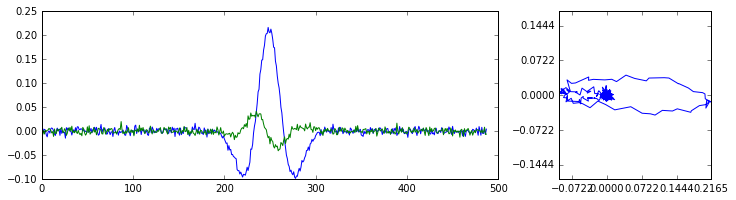

In [3]:
# synthetic data
ricker = signal.ricker(500, 16.0)
pair = np.vstack((ricker,np.zeros(ricker.shape)))
noise = np.random.normal(0,.005,pair.shape)
splitdata = _split(pair+noise,110,12)

def plt_pair(pair):
    from matplotlib import gridspec
    fig = plt.figure(figsize=(12, 3)) 
    gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1]) 
    ax0 = plt.subplot(gs[0])
    ax0.plot(pair.T)
    ax1 = plt.subplot(gs[1])
    ax1.plot(pair[0,:],pair[1,:])
    ticks = np.linspace(-np.abs(pair).max(),np.abs(pair).max(),7)
    ax1.xaxis.set_ticks(ticks)
    ax1.yaxis.set_ticks(ticks)
    plt.axis('equal')
    plt.show()
    
plt_pair(splitdata)

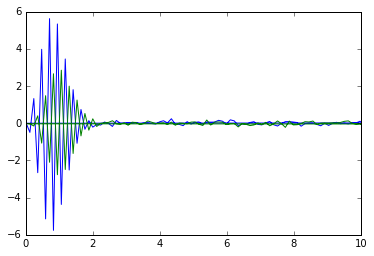

In [4]:
t1 = splitdata[0,:]
sp = np.fft.fft(t1)
freq = np.rad2deg(np.fft.fftfreq(t1.shape[-1]))
plt.plot(freq, sp.real, freq, sp.imag)
plt.xlim(0,10)
plt.show()

In [9]:
np.fft.fft?

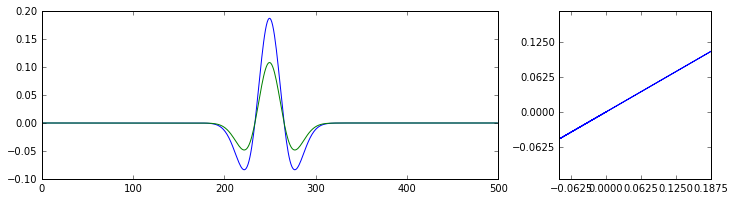

In [12]:
plt_pair(_rotate(pair,30))

In [13]:
f1 = np.fft.fft(pair[0,:])
f2 = np.fft.fft(pair[1,:])

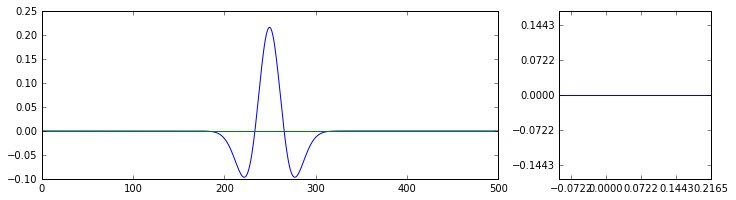

In [41]:
# Forward and reverse Fourier Transform
plt_pair(np.vstack((np.real(np.fft.ifft(f1)),
                            np.real(np.fft.ifft(f2)))))

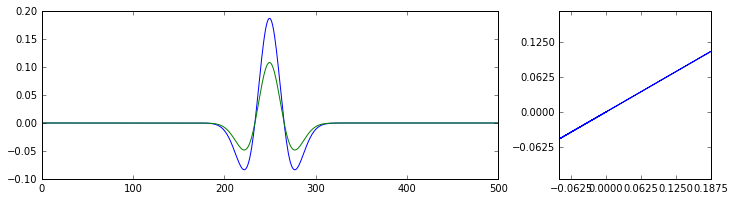

In [44]:
# Rotation in Fourier Domain
rf = _rotate(np.vstack((f1,f2)),30)
data = np.vstack((np.real(np.fft.ifft(rf[0,:])),
                  np.real(np.fft.ifft(rf[1,:]))))
plt_pair(data)

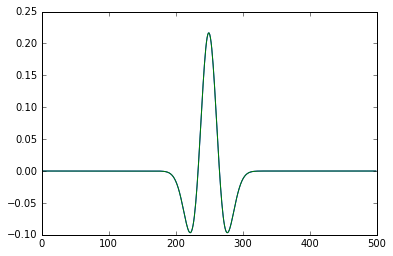

In [246]:
# Shift in the Fourier Domain
# t1 = _taper(splitdata,100)[0,:]
t1 = pair[0,:]
f1 = np.fft.fft(t1)
delta = 1
# shift must be an integer multiple of delta
shift = 0
N = f1.size
P = np.arange(N) * -(2*np.pi * shift)/(delta * N)  
fs = f1 * np.exp(1j*P)
t2 = np.real(np.fft.ifft(fs))
plt.plot(t1)
plt.plot(t2)
# plt.plot(fs.real)
# plt.plot(fs.imag)
# freq = np.rad2deg(np.fft.fftfreq(t1.shape[-1]))
# plt.plot(freq, f1.real, freq, f1.imag)
# plt.xlim(0,4)
# plt.show()


In [87]:
# a = np.array([1,2])
b = np.array([np.pi,np.pi/2])
np.cos(b) + np.sin(b)*1j

array([ -1.00000000e+00 +1.22464680e-16j,   6.12323400e-17 +1.00000000e+00j])

In [234]:
np.cov(t1,t2)

array([[ 0.00200401,  0.00097217],
       [ 0.00097217,  0.00200401]])

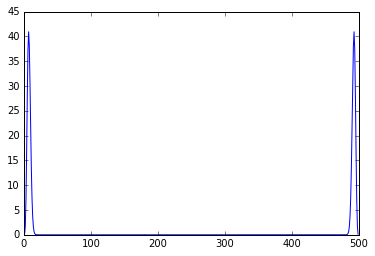

In [247]:
plt.plot(np.abs(f1)**2)

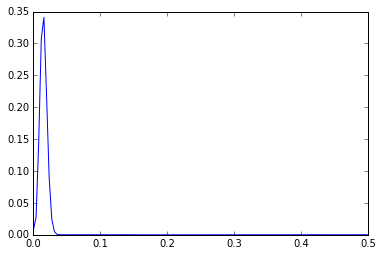

In [250]:
from scipy.signal import welch
f, psd = welch(splitdata[0,:],
               fs=1.,  # sample rate
               window='hanning',   # apply a Hanning window before taking the DFT
               nperseg=256,        # compute periodograms of 256-long segments of x
               detrend='constant') # detrend x by subtracting the mean
plt.plot(f,psd)